# TFRecords 101

#### Why to use TFRecords?

`TPUs` have **eight cores** which act as eight independent workers. We can get data to each core more efficiently by splitting the dataset into multiple files or **shards**. This way, each core can grab an independent part of the data as it needs.

The most convenient kind of file to use for sharding in TensorFlow is a `TFRecord`. A TFRecord is a binary file that contains sequences of byte-strings. Data needs to be `serialized` (encoded as a byte-string) before being written into a TFRecord.

The most convenient way of serializing data in TensorFlow is to wrap the data with `tf.Example`. This is a record format based on Google's protobufs but designed for TensorFlow. It's more or less like a `dict` with some type annotations.

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
    <strong>Walkthrough: Building a Dataset of TFRecords</strong><br>
For an end-to-end walkthrough of building a sharded dataset of TFRecords for labeled images, see <a href="https://www.kaggle.com/ryanholbrook/walkthrough-building-a-dataset-of-tfrecords"><strong>this notebook</strong></a>!
</blockquote>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_sample_image

import tensorflow as tf
from tensorflow.data import Dataset, TFRecordDataset
from tensorflow.data.experimental import TFRecordWriter
from tensorflow.io import FixedLenFeature, VarLenFeature
from tensorflow.train import BytesList, FloatList, Int64List, Example, Features, Feature

from IPython.display import Image

In [2]:
PATH = '/kaggle/working/data.tfrecord'

## Serialization 

A TFRecord is a kind of file that TensorFlow uses to store binary data. TFRecords contain sequences of byte-strings. Here is a very simple TFRecord:

In [3]:
with tf.io.TFRecordWriter(path=PATH) as f:
    f.write(b'123')    # write one record
    f.write(b'xyz314') # write another record

with open(PATH, 'rb') as f:
    print(f.read())

b'\x03\x00\x00\x00\x00\x00\x00\x00\xb0\x99I\x0e123\xce\x0b\xe7\x01\x06\x00\x00\x00\x00\x00\x00\x00si\xd57xyz314\xa0.9y'


A TFRecord is a sequence of bytes, so we have to turn our data into byte-strings before it can go into a TFRecord. We can use `tf.io.serialize_tensor` to turn a tensor into a byte-string and `tf.io.parse_tensor` to turn it back. It's important to keep track of your tensor's datatype (in this case `tf.uint8`) since you have to specify it when parsing the string back to a tensor again.

In [4]:
x = tf.constant([[1, 2], [3, 4]], dtype=tf.uint8)
print('x:', x, '\n')

x_bytes = tf.io.serialize_tensor(x)
print('x_bytes:', x_bytes, '\n')

print('x:', tf.io.parse_tensor(x_bytes, out_type=tf.uint8))

x: tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=uint8) 

x_bytes: tf.Tensor(b'\x08\x04\x12\x08\x12\x02\x08\x02\x12\x02\x08\x02"\x04\x01\x02\x03\x04', shape=(), dtype=string) 

x: tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=uint8)


## tf.data

So how do we write a dataset as a TFRecord? If your dataset is composed of byte-strings, you can use `data.TFRecordWriter`. To read it back again, use `data.TFRecordsDataset`.

In [5]:
# Construct a small dataset
ds = Dataset.from_tensor_slices([b'abc', b'123'])

# Write the dataset to a TFRecord
writer = TFRecordWriter(PATH)
writer.write(ds)
    
# Read the dataset from the TFRecord
ds_2 = TFRecordDataset(PATH)
for x in ds_2:
    print(x)

tf.Tensor(b'abc', shape=(), dtype=string)
tf.Tensor(b'123', shape=(), dtype=string)


If your dataset is composed of tensors, serialize them first by mapping `tf.io.serialize_tensor` over the dataset. Then, when you read them back, map `tf.io.parse_tensor` to turn the byte-strings back into tensors.

In [6]:
# Create a dataset
features = tf.constant([
    [1, 2],
    [3, 4],
    [5, 6],
], dtype=tf.uint8)
ds = Dataset.from_tensor_slices(features)

# Serialize the tensors
ds_bytes = ds.map(tf.io.serialize_tensor)

# Write a TFRecord
writer = TFRecordWriter(PATH)
writer.write(ds_bytes)

# Read it back
ds_bytes_2 = TFRecordDataset(PATH)
ds_2 = ds_2.map(lambda x: tf.io.parse_tensor(x, out_type=tf.uint8))

# They are the same!
for x in ds:
    print(x)
print()
for x in ds_2:
    print(x)

tf.Tensor([1 2], shape=(2,), dtype=uint8)
tf.Tensor([3 4], shape=(2,), dtype=uint8)
tf.Tensor([5 6], shape=(2,), dtype=uint8)

tf.Tensor([1 2], shape=(2,), dtype=uint8)
tf.Tensor([3 4], shape=(2,), dtype=uint8)
tf.Tensor([5 6], shape=(2,), dtype=uint8)


## Serializing Images

Images can be encoded in several ways:
- **raw** encode with `tf.io.serialize_tensor`, decode with `tf.io.parse_tensor`
- **jpeg** encode with `tf.io.encode_jpeg`, decode with `tf.io.decode_jpeg` or `tf.io.decode_and_crop_jpeg`
- **png** encode with `tf.io.encode_png`, decode with `tf.io.decode_png`

Just be sure to use whichever decoder goes with the encoder you chose. Generally, using jpeg encoding for images is a good idea when using TPUs since this can compress the data some, potentially improving data transfer time.

Type <class 'numpy.ndarray'> with dtype uint8


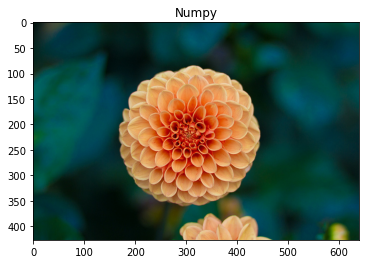

In [7]:
# Load numpy array
image_raw = load_sample_image('flower.jpg')
print("Type {} with dtype {}".format(type(image_raw), image_raw.dtype))
plt.imshow(image_raw)
plt.title("Numpy")
plt.show()

Type <class 'tensorflow.python.framework.ops.EagerTensor'> with dtype <dtype: 'string'>
Sample: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00'


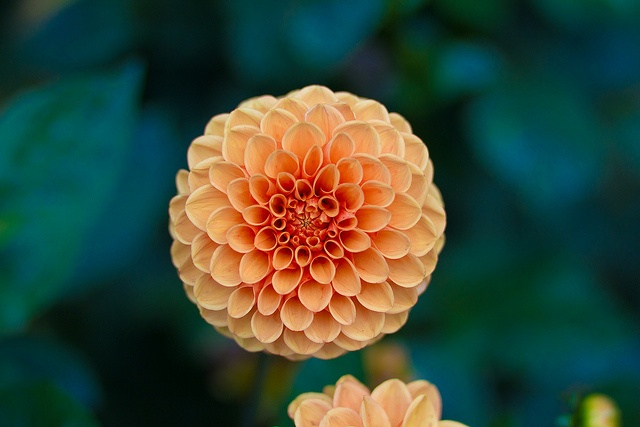

In [8]:
# jpeg encode / decode
image_jpeg = tf.io.encode_jpeg(image_raw)
print("Type {} with dtype {}".format(type(image_jpeg), image_jpeg.dtype))
print("Sample: {}".format(image_jpeg.numpy()[:25]))
Image(image_jpeg.numpy())

Type <class 'tensorflow.python.framework.ops.EagerTensor'> with dtype <dtype: 'uint8'>


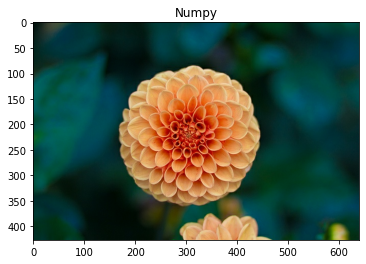

In [9]:
image_raw_2 = tf.io.decode_jpeg(image_jpeg)

print("Type {} with dtype {}".format(type(image_raw_2), image_raw_2.dtype))
plt.imshow(image_raw_2)
plt.title("Numpy")
plt.show()

## tf.Example

What if you have structured data, like `(image, label)` pairs? TensorFlow also includes an API for structured data, `tf.Example`. They are based on Google's [Protocol Buffers](https://developers.google.com/protocol-buffers).

A single `Example` is meant to represent a single instance in a dataset, like a single `(image, label)` pair. Each `Example` has `Features`, described as a `dict` of feature names and values. A value can be either a `BytesList`, a `FloatList`, or an `Int64List`, each wrapped as a single `Feature`. There's no value type for tensors; instead, serialize tensors with `tf.io.serialize_tensor`, get the bytestring with the `numpy` method, and encode them in a `BytesList`.

Here's how we could encode labeled image data:

In [10]:
# The Data
image = tf.constant([ # this could also be a numpy array
    [0, 1, 2],
    [3, 4, 5],
    [6, 7, 8],
])
label = 0
class_name = "Class A"


# Wrap with Feature as a BytesList, FloatList, or Int64List
image_feature = Feature(
    bytes_list=BytesList(value=[
        tf.io.serialize_tensor(image).numpy(),
    ])
)
label_feature = Feature(
    int64_list=Int64List(value=[label]),
)
class_name_feature = Feature(
    bytes_list=BytesList(value=[
        class_name.encode()
    ])
)


# Create a Features dictionary
features = Features(feature={
    'image': image_feature,
    'label': label_feature,
    'class_name': class_name_feature,
})

# Wrap with Example
example = Example(features=features)

print(example)

features {
  feature {
    key: "class_name"
    value {
      bytes_list {
        value: "Class A"
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\003\022\010\022\002\010\003\022\002\010\003\"$\000\000\000\000\001\000\000\000\002\000\000\000\003\000\000\000\004\000\000\000\005\000\000\000\006\000\000\000\007\000\000\000\010\000\000\000"
      }
    }
  }
  feature {
    key: "label"
    value {
      int64_list {
        value: 0
      }
    }
  }
}



All of the data is stored as attributes of the `Example` instance.

In [11]:
print(example.features.feature['label'])

int64_list {
  value: 0
}



Once everything is encoded as an `Example`, you can serialize it with the `SerializeToString` method.

In [12]:
example_bytes = example.SerializeToString()
print(example_bytes)

b'\nl\n\x0e\n\x05label\x12\x05\x1a\x03\n\x01\x00\n?\n\x05image\x126\n4\n2\x08\x03\x12\x08\x12\x02\x08\x03\x12\x02\x08\x03"$\x00\x00\x00\x00\x01\x00\x00\x00\x02\x00\x00\x00\x03\x00\x00\x00\x04\x00\x00\x00\x05\x00\x00\x00\x06\x00\x00\x00\x07\x00\x00\x00\x08\x00\x00\x00\n\x19\n\nclass_name\x12\x0b\n\t\n\x07Class A'


It's nice to wrap all this in a function.

In [13]:
def make_example(image, label, class_name):
    image_feature = Feature(
        bytes_list=BytesList(value=[
            tf.io.serialize_tensor(image).numpy(),
        ])
    )
    label_feature = Feature(
        int64_list=Int64List(value=[
            label,
        ])
    )
    class_name_feature = Feature(
        bytes_list=BytesList(value=[
            class_name.encode(),
        ])
    )

    features = Features(feature={
        'image': image_feature,
        'label': label_feature,
        'class_name': class_name_feature,
    })
    
    example = Example(features=features)
    
    return example.SerializeToString()

In [14]:
example = make_example(
    image=np.array([[1, 2], [3, 4]]),
    label=1,
    class_name="Class B",
)

print(example)

b'\nh\n;\n\x05image\x122\n0\n.\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x02" \x01\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\n\x0e\n\x05label\x12\x05\x1a\x03\n\x01\x01\n\x19\n\nclass_name\x12\x0b\n\t\n\x07Class B'


The whole process might look something like:
1. Build a dataset with `tf.data.Dataset`. You could use the `from_generator` or `from_tensor_slices` methods.
2. Serialize the dataset by iterating over the dataset with `make_example`.
3. Write the dataset to TFRecords with `io.TFRecordWriter` or `data.TFRecordWriter`.

Note, however, that to use a function like `make_example` with the `Dataset` map method you'll need to wrap it with `tf.py_function` first since TensorFlow executes dataset transformations in graph mode. You could write something like this:

```python
ds_bytes = ds.map(lambda image, label: tf.py_function(func=make_example, inp=[image, label], Tout=tf.string))
```

See the [API docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) for more info.

For TPU training, you'll want to shard the dataset into multiple files. the `Dataset.shard` method is handy for this, and Kaggle's [TPU documentation](https://www.kaggle.com/docs/tpu#tpu3) gives some advice about constructing shards.

## Parsing Serialized Examples

To decode a serialized example, we need to give TensorFlow a description of what kind of data to expect. We have just scalar entries for each so we can use `FixedLenFeature`. Pass the description to `tf.io.parse_single_example` along with the serialized example.

In [15]:
feature_description = {
    'image': FixedLenFeature([], tf.string),
    'label': FixedLenFeature([], tf.int64),
    'class_name': FixedLenFeature([], tf.string),
}

example_2 = tf.io.parse_single_example(example, feature_description)
print("Parsed:   ", example_2)

Parsed:    {'class_name': <tf.Tensor: shape=(), dtype=string, numpy=b'Class B'>, 'image': <tf.Tensor: shape=(), dtype=string, numpy=b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x02" \x01\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00'>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>}


These are the functions from the helper script that assemble the dataset from the TFRecords. We haven't covered everything here, but hopefully it's a little more clear what's going on.

In [16]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs


def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

## More Resources

- [TPU-speed data pipelines: tf.data.Dataset and TFRecords](https://codelabs.developers.google.com/codelabs/keras-flowers-data/#4)
- [Protocol Buffers](https://developers.google.com/protocol-buffers/)
- [TFRecord and tf.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord)

## Reference

This notebook is replica of this source [notebook](https://www.kaggle.com/ryanholbrook/tfrecords-basics)

---